## Multilayered planar waveguide mode calculator

Use the sliders to set the wavelength $\lambda$, the thickness of each layer $d_{1..3}$, and the refractive indices $n_{0..4}$ (including the ones of the incidence and substrate media).

To disable any layer just keep its thickness at zero.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import ipywidgets as widgets
from scipy import optimize
from matplotlib.ticker import MaxNLocator
%matplotlib widget

plt.style.use('bmh')

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.formatter.useoffset'] = False #to avoid the auto-offset on axes

In [3]:
def multilayersolve(thickness,n,thetadeg,pol,wavelength):
    """
    Transfer-matrix method using electric fiels propagating to right and left, from scattering matrices.
    R,T = multilayersolve(th,n,thetadeg,pol,wavel)
    thickness: layer thickness vector (with same units as wavelength)
    n: index vector, including air and substrate at beginning and end. Must have 2 more elements than th.
    thetadeg: incidence angle in deg.
    pol: 1 for TE and -1 for TM
    wavelength = wavelength vector, must have same units as th.
        
    """

    num_lay=thickness.size
    num_w = wavelength.size
    if n.ndim == 1:
        n_mat = np.reshape(np.repeat(n,num_w),(num_lay+2,num_w))
    else:
        n_mat = n
    
    neff0 = n_mat[0]*np.sin(thetadeg/180.*np.pi)
    neff0_sq = neff0 **2
    k0 = 2*np.pi/wavelength
    
    g_air = np.sqrt(n_mat[0]**2-neff0_sq+0j)
    g_su = np.sqrt(n_mat[-1]**2-neff0_sq+0j)
    if pol == -1:
        g_air=g_air/n_mat[0]**2
        g_su=g_su/n_mat[-1]**2
    
    ncostheta=np.sqrt(n_mat[1]**2-neff0_sq+0j)
    gamma=ncostheta
    if pol==-1:
         gamma=gamma/n_mat[1]**2
    
    coeff = gamma/g_air
    t11=.5*(1+coeff)+0j
    t12=.5*(1-coeff)+0j
    t21=t12
    t22=t11
    

    
    for ii in range(num_lay):
    
        delta=k0*thickness[ii]*ncostheta

        prop=np.exp(-1j*delta)
        t11=t11*prop
        t12=t12/prop
        t21=t21*prop
        t22=t22/prop

        ncosthetanew = np.sqrt(n_mat[ii+2]**2-neff0_sq+0j)
        gammanew=ncosthetanew
        if pol==-1:
            gammanew=gammanew/n_mat[ii+2]**2

        coeff=gammanew/gamma;

        m11=0.5*(1+coeff)
        m12=0.5*(1-coeff)
        m21=m12
        m22=m11

        t11new=t11*m11+t12*m21   #Transfer matrix until this layer
        t12new=t11*m12+t12*m22
        t21new=t21*m11+t22*m21
        t22=t21*m12+t22*m22

        t11=t11new
        t12=t12new
        t21=t21new
        
        ncostheta = ncosthetanew
        gamma=gammanew
    
    tra=1/t11
    ref=t21*tra

    REF=abs(ref)**2
    TRA=abs(tra)**2.*np.real(g_su)/np.real(g_air)
    
    return REF, TRA

def gen_prof(thickness,n,tails=200.):
    """
    Generates the index profile from list of thicknesses and index.
    z_prof, n_prof = gen_prof(thickness,n,tails=100)
    thickness: thickness array
    n: index array list, with air and substrate as first and last elements, which means its length must be 2 elements more than thickness
    tails is the lengths assigned to the air and substrate layers, def = 100
    """
    n = np.real(n)
    
    thickness_with_tails = np.concatenate(([tails],thickness,[tails]))
    n = n[thickness_with_tails>0]
    thickness_with_tails=thickness_with_tails[thickness_with_tails>0]
    
    dz_tail = tails
    #thickness = np.concatenate([np.array([dz_tail]),thickness,np.array([dz_tail])])
    z_prof = np.zeros(2*(thickness_with_tails.size))
    n_prof = np.zeros(2*(thickness_with_tails.size))

    z_0 = -dz_tail
    
    for ii in range(len(thickness_with_tails)):
        n_prof[(2*ii):(2*ii+2)]=n[ii]
        
        z_prof[2*ii]=z_0
        z_0 += thickness_with_tails[ii]
        z_prof[2*ii+1]=z_0
    return z_prof, n_prof


In [4]:
def multilayersolve_wg(thickness,n,neff,pol,wavelength):
    """
    It returns just t11, used to find its zeros for finding waveguide modes.
    """


    #num_neff = neff.size

    
    thickness_with_tails = np.concatenate(([10.],thickness,[10.]))

    n = n[thickness_with_tails>0]
    thickness=thickness[thickness>0]
    

    num_lay=thickness.size
    
    n_mat = n
    
    neff_sq = neff**2
    k0 = 2*np.pi/wavelength
    
    g_air = np.sqrt(n_mat[0]**2-neff_sq+0j)
    if pol == -1:
        g_air=g_air/n_mat[0]**2
    
    ncostheta=np.sqrt(n_mat[1]**2-neff_sq+0j)
    gamma=ncostheta
    if pol==-1:
         gamma=gamma/n_mat[1]**2
    
    coeff = gamma/g_air
    t11=.5*(1+coeff)+0j
    t12=.5*(1-coeff)+0j
    t21=t12
    t22=t11
    

    
    for ii in range(num_lay):
    
        delta=k0*thickness[ii]*ncostheta

        prop=np.exp(-1j*delta)
        t11=t11*prop
        t12=t12/prop
        t21=t21*prop
        t22=t22/prop

        ncosthetanew = np.sqrt(n_mat[ii+2]**2-neff_sq+0j)
        gammanew=ncosthetanew
        if pol==-1:
            gammanew=gammanew/n_mat[ii+2]**2

        coeff=gammanew/gamma;

        m11=0.5*(1+coeff)
        m12=0.5*(1-coeff)
        m21=m12
        m22=m11

        t11new=t11*m11+t12*m21   #Transfer matrix until this layer
        t12new=t11*m12+t12*m22
        t21new=t21*m11+t22*m21
        t22=t21*m12+t22*m22

        t11=t11new
        t12=t12new
        t21=t21new
        
        ncostheta = ncosthetanew
        gamma=gammanew
    
    
    return t11



In [5]:
def zero_func(neff,thickness,n,pol,wavelength):
    return np.real(multilayersolve_wg(thickness,n,neff,pol,wavelength))
    


def find_mode_neffs(thickness,n,pol,wavelength,neff_range=None,N_neffs=3000,margin_top = 1E-8,margin_bott = 1E-6):
    if not(neff_range):
        neff_max = np.max(n)-margin_top
        neff_min = max([n[0],n[-1]])+margin_bott
        X = np.linspace(neff_min,neff_max,N_neffs)
    else:
        X = np.linspace(neff_range[0],neff_range[1],N_neffs)
    
    f=np.real(multilayersolve_wg(thickness,n,X,pol,wavelength))
    
    tt = len(X)
    zeros = []
    brackets = []

    for ii in range(tt - 1):
        
        if f[ii] * f[ii + 1] < 0:  # change of sign
            
            if ii != 0 and ii != tt - 2:  # not at an extreme
                
                if abs(f[ii - 1] - f[ii + 2]) > abs(f[ii] - f[ii + 1]):  # not an asymptote
                    brackets += [[X[ii], X[ii + 1]]]
                    
            else:
                brackets += [[X[ii], X[ii + 1]]]
    
    sols = []
    
    for br in brackets:
        optimum = optimize.root_scalar(zero_func, args=(thickness,n,pol,wavelength), bracket=br, method='brentq')
        sols.append(optimum)

    return np.array([a.root for a in sols])

In [6]:
def calc_E_prof(thickness,n,neff,pol,wavelength,z):
    """
    """
    
    E=0j*np.zeros(len(z))
    thickness_with_tails = np.concatenate(([10.],thickness,[10.]))
    n = n[thickness_with_tails>0]
    thickness=thickness[thickness>0]
   
    num_lay=thickness.size
    #num_neff = neff.size
    n_mat = n
    
    neff_sq = neff**2
    k0 = 2*np.pi/wavelength
    ncostheta_air = np.sqrt(n_mat[0]**2-neff_sq+0j)
    g_air = ncostheta_air
    if pol == -1:
        g_air=g_air/n_mat[0]**2
    
    E_plus = 0j
    E_minus = 1+0j
    E[z<=0]=E_minus*np.exp(-1j*k0*ncostheta_air*z[z<=0])
    if pol==-1:
        E = E*neff/n_mat[0]
                      
    
    ncostheta=np.sqrt(n_mat[1]**2-neff_sq+0j)
    gamma=ncostheta
    if pol==-1:
         gamma=gamma/n_mat[1]**2
    
    coeff = g_air/gamma
    tt11=.5*(1+coeff)+0j
    tt12=.5*(1-coeff)+0j
    tt21=tt12
    tt22=tt11
    
    curr_z = 0.
    
    E_plus_new = E_plus*tt11+E_minus*tt12
    E_minus = E_plus*tt21+E_minus*tt22
    E_plus = E_plus_new

    
    for ii in range(num_lay):
        
       
        condition = (z>curr_z) & (z<=(curr_z+thickness[ii]))
        if pol == 1:
            E[condition]=E_plus*np.exp(1j*k0*ncostheta*(z[condition]-curr_z))+E_minus*np.exp(-1j*k0*ncostheta*(z[condition]-curr_z))
        else:
            E[condition]=(E_plus*np.exp(1j*k0*ncostheta*(z[condition]-curr_z))+E_minus*np.exp(-1j*k0*ncostheta*(z[condition]-curr_z)))*neff/n_mat[ii+1]
       
        curr_z += thickness[ii]
               
        delta=k0*thickness[ii]*ncostheta

        prop=np.exp(1j*delta)
        E_plus = E_plus*prop
        E_minus = E_minus/prop
        
        # tt11=tt11*prop
        # tt12=tt12/prop
        # tt21=tt21*prop
        # tt22=tt22/prop

        ncosthetanew = np.sqrt(n_mat[ii+2]**2-neff_sq+0j)
        gammanew=ncosthetanew
        if pol==-1:
            gammanew=gammanew/n_mat[ii+2]**2

        coeff=gamma/gammanew;

        tt11=0.5*(1+coeff)
        tt12=0.5*(1-coeff)
        tt21=tt12
        tt22=tt11
        
        E_plus_new = E_plus*tt11+E_minus*tt12
        E_minus = E_plus*tt21+E_minus*tt22
        E_plus = E_plus_new

#         t11new=t11*m11+t12*m21   #Transfer matrix until this layer
#         t12new=t11*m12+t12*m22
#         t21new=t21*m11+t22*m21
#         t22=t21*m12+t22*m22

#         t11=t11new
#         t12=t12new
#         t21=t21new
        
        ncostheta = ncosthetanew
        gamma=gammanew
    
    condition = z>curr_z
    if pol == 1:
        E[condition]=E_plus*np.exp(1j*k0*ncostheta*(z[condition]-curr_z))
    else:
        E[condition]=E_plus*np.exp(1j*k0*ncostheta*(z[condition]-curr_z))*neff/n_mat[-1]
    
    E = E/np.max(np.abs(E))/2
    return np.real(E)

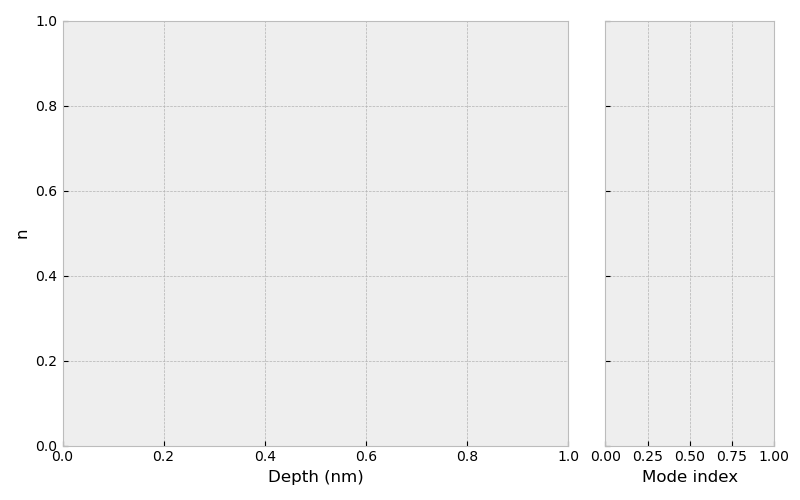

In [8]:


layout_slider=widgets.Layout(width='400px')

layout_text = widgets.Layout(width='150px')

index_list_init = np.array([1.0, 3.5, 1.444, 3.5, 1.444])
thickness_list_init = np.array([220.,0.,0.])

slider_w = widgets.FloatSlider(min=100, max=2000, value=1550., description = "\u03BB 0",
                                layout=layout_slider)
sliders_n = [widgets.FloatSlider(min=1., max=4.0, value=index_list_init[ii], step = 0.01, description = f"n{ii}",
                                layout=layout_slider) for ii in range(len(index_list_init))]
sliders_th = [widgets.FloatSlider(min=0., max=4000., value=thickness_list_init[ii], step= 1, description = f"d{ii+1}",
                                  layout=layout_slider) for ii in range(len(thickness_list_init))]
layout_center = widgets.Layout(display="flex", justify_content="center")
label_mode_order = [widgets.Label('', layout = layout_center) for aa in range(50)]
label_list_neff_TE = [widgets.Label('',layout = layout_center) for aa in range(50)]
label_list_neff_TM = [widgets.Label('',layout= layout_center) for aa in range(50)]

col_mode_order = widgets.VBox([], layout = widgets.Layout(width = '100px'))
col_neffs_TE = widgets.VBox([], layout = widgets.Layout(width = '100px'))
col_neffs_TM = widgets.VBox([], layout = widgets.Layout(width = '100px'))
neffs_data = widgets.HBox([widgets.VBox([widgets.Label('Mode index', layout= layout_center),col_mode_order]),
                           widgets.VBox([widgets.Label('neff TE list', layout= layout_center),col_neffs_TE]),
                           widgets.VBox([widgets.Label('neff TM list', layout= layout_center),col_neffs_TM])])

def calc_modes(obj):
    w = slider_w.value
    n_list = np.array([slider.value for slider in sliders_n])
    th_list = np.array([slider.value for slider in sliders_th])
    
    thickness_with_tails = np.concatenate(([10.],th_list,[10.]))
    n_list = n_list[thickness_with_tails>0]
    th_list=th_list[th_list>0]
    
    neffs_TE = find_mode_neffs(thickness=th_list,n=n_list,pol=1,wavelength=w)
    neffs_TM = find_mode_neffs(thickness=th_list,n=n_list,pol=-1,wavelength=w)
    
    extra_margin = 500.
    z_mode = np.linspace(-extra_margin,np.sum(th_list)+extra_margin,800)
    E_modes_TE = np.array([calc_E_prof(th_list,n_list,my_neff,1,w,z_mode) for my_neff in neffs_TE]).T
    E_modes_TM = np.array([calc_E_prof(th_list,n_list,my_neff,-1,w,z_mode) for my_neff in neffs_TM]).T
       
    
    z_prof,n_prof = gen_prof(th_list,n_list,tails=extra_margin)
    ax.clear()
#     ax2.clear()
    ax.plot([],[])
    ax.plot([],[]) #just for the legends
    ax.plot(z_prof,n_prof,linewidth = 2,color='gray')
    [ax.axhline(y=my_neff, color='C0', linestyle='--') for my_neff in neffs_TE]
    [ax.axhline(y=my_neff, color='C1', linestyle='--') for my_neff in neffs_TM]
    [ax.plot(z_mode,E_modes_TE[:,ii]+neffs_TE[ii],color='C0') for ii in range(len(neffs_TE))]
    [ax.plot(z_mode,E_modes_TM[:,ii]+neffs_TM[ii],color='C1') for ii in range(len(neffs_TM))]
#     ax2.plot(z_mode,E_modes_TE,color = 'C1')
#     ax2.plot(z_mode,E_modes_TM,color = 'C2')
    ax.set_xlabel('Depth (nm)')
    ax.set_ylabel('n')
    ax.legend(['TE','TM'], loc = 'upper right')
    
    for aa in label_list_neff_TE:
        aa.value = ''
    for ii,my_neff in enumerate(neffs_TE[::-1]):
        label_list_neff_TE[ii].value = f'{my_neff:.5f}'
    col_neffs_TE.children = label_list_neff_TE[:(len(neffs_TE))]

    for aa in label_list_neff_TM:
        aa.value = ''
    for ii,my_neff in enumerate(neffs_TM[::-1]):
        label_list_neff_TM[ii].value = f'{my_neff:.5f}'
    col_neffs_TM.children = label_list_neff_TM[:(len(neffs_TM))]
    
    for aa in label_mode_order:
        aa.value = ''
    for ii in range(len(neffs_TE)):
        label_mode_order[ii].value = f'{ii+1}'
    col_mode_order.children = label_mode_order[:(len(neffs_TE))]
    
    ax2.clear()
    ax2.plot(np.arange(len(neffs_TE))+1,neffs_TE[::-1],'.')
    ax2.plot(np.arange(len(neffs_TM))+1,neffs_TM[::-1],'.')
    neff_max = max(n_list)
    neff_min = max([n_list[0],n_list[-1]])
    ax2.axhline(neff_max,linewidth=1, color='black', linestyle = 'dashed')
    ax2.axhline(neff_min,linewidth=1, color='black',linestyle = 'dashed')
    ax2.set_ylim(ax.get_ylim())
    #ax2.legend(['TE','TM'],loc = 'upper right')
    ax2.set_xlabel('Mode index')
    ax2.set_yticklabels([])
    #ax2.set_ylabel('$neff$')
    
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    if len(neffs_TE) <=1:
        ax2.set_xticks([1.0])
    fig.canvas.draw()    
#     ax2.set_xlabel('Depth (nm)')
#     ax2.set_ylabel('E')


col1= widgets.VBox([slider_w]+sliders_th)
col2= widgets.VBox(sliders_n)
all_controls = widgets.HBox([col1,col2])


display(all_controls)    
    
fig,(ax,ax2) = plt.subplots(1,2,figsize = (8.,5.),gridspec_kw={'width_ratios': [3,1]})
ax.set_xlabel('Depth (nm)')
ax.set_ylabel('n')
# ax1.set_xlabel('Depth (nm)')
# ax1.set_ylabel('n')
# ax2.set_xlabel('Depth (nm)')
# ax2.set_ylabel('E')
ax2.set_xlabel('Mode index')
ax2.set_yticklabels([])
#ax2.set_ylabel('$neff$')
fig.canvas.header_visible = False
fig.tight_layout()
plt.show()

calc_modes(None)

display(neffs_data)

all_sliders = sliders_n+sliders_th+[slider_w]
[slider.observe(calc_modes,names = 'value') for slider in all_sliders]

None
